In [ ]:
import pandas as pd

df = pd.read_csv('/content/train_stock_data.csv')
df2 = pd.read_csv('/content/validation_stock_data.csv')

df_categorized_new = {}

df_combined = pd.concat([df, df2], ignore_index=True)

for cat in df_combined['Ticker'].unique():
    temp_df = df_combined[df_combined['Ticker'] == cat].copy()
    temp_df.dropna(axis=1, how='all', inplace=True)
    df_categorized_new[cat] = temp_df

def renameCol(df):
  df.columns = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']
  return df

In [ ]:
for cat in df_categorized_new:
  df_categorized_new[cat] = renameCol(df_categorized_new[cat])

df_categorized_new['JPM'].head()

,Date,Ticker,Open,High,Low,Close,Volume
4032,2019-01-02,JPM,80.110864,83.308621,80.102520,82.916206,15670900.0
4033,2019-01-03,JPM,83.025637,83.236062,81.384317,81.737831,16286400.0
4034,2019-01-04,JPM,83.421244,84.953144,82.722628,84.751137,16935200.0
4035,2019-01-07,JPM,84.532280,85.407652,83.926252,84.810043,15430700.0
4036,2019-01-08,JPM,85.542350,85.702276,83.791611,84.650146,13578800.0


In [ ]:
import json

with open('hyperedges.json', 'r') as f:
    hyperedges = json.load(f)

print("Categories (Hyperedges):")
for category in hyperedges:
    print(f"- {category}: {hyperedges[category]}")


Categories (Hyperedges):
- Tech: ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
- Finance: ['JPM', 'BAC', 'C']
- Healthcare: ['JNJ', 'PFE', 'MRK']
- Energy: ['XOM', 'CVX']
- Consumer: ['WMT', 'PG', 'KO']
- Industrials: ['BA', 'CAT']
- Communications: ['VZ', 'T']
- Utilities: ['DUK']


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def add_technical_indicators(df):
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['STD20'] = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = df['MA20'] + (df['STD20'] * 2)
    df['Lower_Band'] = df['MA20'] - (df['STD20'] * 2)
    df['Momentum'] = df['Close'] - df['Close'].shift(4)
    return df

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

class HypergraphConv(nn.Module):
    def __init__(self, in_features, out_features):
        super(HypergraphConv, self).__init__()
        self.W = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.bias = nn.Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W)
        nn.init.zeros_(self.bias)

    def forward(self, X, H, D_v_inv, D_e_inv):
        X = torch.matmul(X, self.W)  # XW
        X = torch.matmul(D_v_inv, X)  # D_v^(-1) XW
        X = torch.matmul(H.T, X)  # H D_v^(-1) XW
        X = torch.matmul(D_e_inv, X)  # D_e^(-1) H D_v^(-1) XW
        X = torch.matmul(H, X)  # H^T D_e^(-1) H D_v^(-1) XW

        return X + self.bias

class HGNN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, dropout=0.5):
        super(HGNN, self).__init__()
        self.hgconv1 = HypergraphConv(in_features, hidden_features)
        self.hgconv2 = HypergraphConv(hidden_features, hidden_features)
        self.fc = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X, H, D_v_inv, D_e_inv):
        X = F.relu(self.hgconv1(X, H, D_v_inv, D_e_inv))
        X = self.dropout(X)
        X = F.relu(self.hgconv2(X, H, D_v_inv, D_e_inv))
        X = self.dropout(X)
        return self.fc(X)

class StockPredictionModel(nn.Module):
    def __init__(self, seq_length, feature_size, hidden_size, output_size, num_nodes, num_edges):
        super(StockPredictionModel, self).__init__()
        self.lstm = nn.LSTM(feature_size, hidden_size, batch_first=True)
        self.hgnn = HGNN(hidden_size, hidden_size*2, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, H, D_v_inv, D_e_inv):
        batch_size, seq_len, num_nodes, feat_size = x.size()
        x = x.view(batch_size * num_nodes, seq_len, feat_size)
        self.lstm.flatten_parameters()
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = x.view(batch_size, num_nodes, -1)
        outputs = []
        for i in range(batch_size):
            out = self.hgnn(x[i], H, D_v_inv, D_e_inv)
            outputs.append(out)

        x = torch.stack(outputs, dim=0)
        x = x.view(batch_size * num_nodes, -1)
        x = self.fc(x)

        return x.view(batch_size, num_nodes, -1)


def prepare_data_and_train_model(df_categorized, hyperedges, validation_tickers, seq_length=30):
    all_tickers = []
    for category in hyperedges:
        all_tickers.extend(hyperedges[category])
    all_tickers = sorted(list(set(all_tickers)))
    ticker_to_idx = {ticker: idx for idx, ticker in enumerate(all_tickers)}

    num_nodes = len(all_tickers)
    num_edges = len(hyperedges)

    H = torch.zeros((num_nodes, num_edges)).to(device)
    for edge_idx, category in enumerate(hyperedges):
        for ticker in hyperedges[category]:
            node_idx = ticker_to_idx[ticker]
            H[node_idx, edge_idx] = 1
    D_v = torch.sum(H, dim=1)
    D_e = torch.sum(H, dim=0)
    eps = 1e-10
    D_v_inv = torch.diag(1.0 / (D_v + eps)).to(device)
    D_e_inv = torch.diag(1.0 / (D_e + eps)).to(device)
    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume',
                      'MA5', 'MA20', 'RSI', 'MACD', 'Signal',
                      'Upper_Band', 'Lower_Band', 'Momentum']

    scalers = {ticker: {col: MinMaxScaler() for col in feature_columns}
              for ticker in all_tickers}

    processed_data = {}
    for ticker in all_tickers:
        if ticker in df_categorized:
            stock_df = df_categorized[ticker].copy()
            train_df = stock_df[stock_df['Date'].dt.year < 2023].copy()
            train_df = add_technical_indicators(train_df)
            train_df = train_df.ffill().bfill()
            scaled_data = train_df[feature_columns].copy()
            for col in feature_columns:
                scaled_data[col] = scalers[ticker][col].fit_transform(train_df[[col]])
            X, y = create_sequences(scaled_data.values, seq_length)

            processed_data[ticker] = {
                'X': X,
                'y': y,
                'scalers': scalers[ticker]
            }
    train_tickers = [ticker for ticker in all_tickers if ticker not in validation_tickers]

    feature_size = len(feature_columns)
    hidden_size = 64
    output_size = 5  # Open, High, Low, Close, Volume

    model = StockPredictionModel(
        seq_length=seq_length,
        feature_size=feature_size,
        hidden_size=hidden_size,
        output_size=output_size,
        num_nodes=num_nodes,
        num_edges=num_edges
    ).to(device)
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    num_epochs = 50
    batch_size = 32

    X_train_batches = []
    y_train_batches = []

    for ticker in train_tickers:
        if ticker in processed_data:
            X = processed_data[ticker]['X']
            y = processed_data[ticker]['y']

            y = y[:, :output_size]
            for i in range(0, len(X), batch_size):
                batch_X = X[i:i+batch_size]
                batch_y = y[i:i+batch_size]

                if len(batch_X) < batch_size:
                    continue

                batch_X_all_nodes = torch.zeros(batch_size, seq_length, num_nodes, feature_size)
                batch_y_all_nodes = torch.zeros(batch_size, num_nodes, output_size)

                node_idx = ticker_to_idx[ticker]
                batch_X_all_nodes[:, :, node_idx, :] = torch.FloatTensor(batch_X)
                batch_y_all_nodes[:, node_idx, :] = torch.FloatTensor(batch_y)

                batch_X_all_nodes = batch_X_all_nodes.to(device)
                batch_y_all_nodes = batch_y_all_nodes.to(device)

                X_train_batches.append(batch_X_all_nodes)
                y_train_batches.append(batch_y_all_nodes)

    model.train()
    best_model = None
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        total_loss = 0

        indices = np.random.permutation(len(X_train_batches))

        for idx in tqdm(indices, desc=f"Epoch {epoch+1}/{num_epochs}"):
            X_batch = X_train_batches[idx]
            y_batch = y_train_batches[idx]

            model.train()
            optimizer.zero_grad()
            outputs = model(X_batch, H, D_v_inv, D_e_inv)

            mask = (y_batch != 0).float()
            loss = criterion(outputs * mask, y_batch * mask)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(indices)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.6f}")

        val_loss = validate_model(model, processed_data, validation_tickers,
                                 ticker_to_idx, H, D_v_inv, D_e_inv,
                                 num_nodes, feature_size, output_size, seq_length)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            torch.save(best_model.state_dict(), 'best_hypergraph_model.pth')

    return best_model, scalers, ticker_to_idx, H, D_v_inv, D_e_inv

def validate_model(model, processed_data, validation_tickers, ticker_to_idx,
                  H, D_v_inv, D_e_inv, num_nodes, feature_size, output_size, seq_length):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0
    batch_size = 32

    with torch.no_grad():
        for ticker in validation_tickers:
            if ticker in processed_data:
                X = processed_data[ticker]['X']
                y = processed_data[ticker]['y']

                y = y[:, :output_size]
                for i in range(0, len(X), batch_size):
                    batch_X = X[i:i+batch_size]
                    batch_y = y[i:i+batch_size]

                    if len(batch_X) < batch_size:
                        continue

                    batch_X_all_nodes = torch.zeros(batch_size, seq_length, num_nodes, feature_size)
                    batch_y_all_nodes = torch.zeros(batch_size, num_nodes, output_size)

                    node_idx = ticker_to_idx[ticker]
                    batch_X_all_nodes[:, :, node_idx, :] = torch.FloatTensor(batch_X)
                    batch_y_all_nodes[:, node_idx, :] = torch.FloatTensor(batch_y)

                    batch_X_all_nodes = batch_X_all_nodes.to(device)
                    batch_y_all_nodes = batch_y_all_nodes.to(device)

                    outputs = model(batch_X_all_nodes, H, D_v_inv, D_e_inv)

                    mask = (batch_y_all_nodes != 0).float()
                    loss = criterion(outputs * mask, batch_y_all_nodes * mask)

                    total_loss += loss.item()

    avg_val_loss = total_loss / len(validation_tickers)
    print(f"Validation Loss: {avg_val_loss:.6f}")

    return avg_val_loss

def predict_stock_2023(model, df_categorized, ticker, scalers, ticker_to_idx,
                      H, D_v_inv, D_e_inv, num_nodes, feature_size, output_size, seq_length):
    model.eval()
    stock_df = df_categorized[ticker].copy()
    train_df = stock_df[stock_df['Date'].dt.year < 2023].copy()

    train_df = add_technical_indicators(train_df)

    train_df = train_df.ffill().bfill()


    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume',
                      'MA5', 'MA20', 'RSI', 'MACD', 'Signal',
                      'Upper_Band', 'Lower_Band', 'Momentum']

    last_sequence = train_df[feature_columns].tail(seq_length).copy()

    for col in feature_columns:
        last_sequence[col] = scalers[ticker][col].transform(last_sequence[[col]])

    sequence_tensor = torch.FloatTensor(last_sequence.values).unsqueeze(0)
    X_all_nodes = torch.zeros(1, seq_length, num_nodes, feature_size).to(device)

    node_idx = ticker_to_idx[ticker]
    X_all_nodes[0, :, node_idx, :] = sequence_tensor.to(device)

    with torch.no_grad():
        output = model(X_all_nodes, H, D_v_inv, D_e_inv)

    predicted_values = output[0, node_idx, :].cpu().numpy()

    predictions = {}
    predictions['Open'] = scalers[ticker]['Open'].inverse_transform(predicted_values[0].reshape(1, -1))[0][0]
    predictions['High'] = scalers[ticker]['High'].inverse_transform(predicted_values[1].reshape(1, -1))[0][0]
    predictions['Low'] = scalers[ticker]['Low'].inverse_transform(predicted_values[2].reshape(1, -1))[0][0]
    predictions['Close'] = scalers[ticker]['Close'].inverse_transform(predicted_values[3].reshape(1, -1))[0][0]
    predictions['Volume'] = scalers[ticker]['Volume'].inverse_transform(predicted_values[4].reshape(1, -1))[0][0]

    return predictions

def generate_predictions_for_2023(model, df_categorized, tickers_to_predict, scalers, ticker_to_idx,
                                 H, D_v_inv, D_e_inv, num_nodes, feature_size, output_size, seq_length):
    """Generate predictions for 2023 for all tickers not in validation set"""
    predictions = {}
    start_date = pd.Timestamp('2023-01-01')
    end_date = pd.Timestamp('2023-12-31')
    dates = pd.date_range(start=start_date, end=end_date, freq='W-MON')

    for ticker in tickers_to_predict:
        if ticker in df_categorized:
            ticker_predictions = []

            initial_pred = predict_stock_2023(
                model, df_categorized, ticker, scalers, ticker_to_idx,
                H, D_v_inv, D_e_inv, num_nodes, feature_size, output_size, seq_length
            )

            ticker_predictions.append({
                'date': dates[0].strftime('%Y-%m-%d'),
                'predicted_open': initial_pred['Open'],
                'predicted_high': initial_pred['High'],
                'predicted_low': initial_pred['Low'],
                'predicted_close': initial_pred['Close'],
                'predicted_volume': initial_pred['Volume']
            })

            prev_open = initial_pred['Open']
            prev_high = initial_pred['High']
            prev_low = initial_pred['Low']
            prev_close = initial_pred['Close']
            prev_volume = initial_pred['Volume']

            for date in dates[1:]:
                # Create a temporary dataframe to update with new predictions
                temp_df = df_categorized[ticker].copy()

                # Add the previous prediction as a new row
                new_row = pd.DataFrame({
                    'Date': [dates[0]],
                    'Ticker': [ticker],
                    'Open': [prev_open],
                    'High': [prev_high],
                    'Low': [prev_low],
                    'Close': [prev_close],
                    'Volume': [prev_volume]
                })

                temp_df = pd.concat([temp_df, new_row], ignore_index=True)

                next_pred = predict_stock_2023(
                    model, {ticker: temp_df}, ticker, scalers, ticker_to_idx,
                    H, D_v_inv, D_e_inv, num_nodes, feature_size, output_size, seq_length
                )

                ticker_predictions.append({
                    'date': date.strftime('%Y-%m-%d'),
                    'predicted_open': next_pred['Open'],
                    'predicted_high': next_pred['High'],
                    'predicted_low': next_pred['Low'],
                    'predicted_close': next_pred['Close'],
                    'predicted_volume': next_pred['Volume']
                })

                prev_open = next_pred['Open']
                prev_high = next_pred['High']
                prev_low = next_pred['Low']
                prev_close = next_pred['Close']
                prev_volume = next_pred['Volume']

            predictions[ticker] = ticker_predictions

    return predictions

def generate_test_cases_file(predictions):
    test_cases = []

    for ticker in predictions:
        for pred in predictions[ticker]:
            test_case = {
                "ticker": ticker,
                "date": pred['date'],
                "predicted_open": pred['predicted_open'],
                "predicted_high": pred['predicted_high'],
                "predicted_low": pred['predicted_low'],
                "predicted_close": pred['predicted_close'],
                "predicted_volume": pred['predicted_volume'],
                "eval_metric": "MAPE"
            }
            test_cases.append(test_case)

    # Save to JSON file
    with open('test_cases.json', 'w') as f:
        json.dump(test_cases, f, indent=2)

    return test_cases

def evaluate_model_on_validation(model, df_categorized, validation_tickers, scalers, ticker_to_idx,
                               H, D_v_inv, D_e_inv, num_nodes, feature_size, output_size, seq_length):
    """Evaluate model on validation set and calculate MAPE"""
    mape_scores = {}

    for ticker in validation_tickers:
        if ticker in df_categorized:
            # Get actual 2023 data
            stock_df = df_categorized[ticker].copy()
            actual_df = stock_df[stock_df['Date'].dt.year == 2023].copy()

            if len(actual_df) == 0:
                print(f"No 2023 data available for {ticker}. Skipping evaluation.")
                continue

            # Generate predictions for 2023
            predictions = []

            # Get the dates for 2023 (weekly)
            actual_dates = actual_df['Date'].unique()
            weekly_dates = []
            for i, date in enumerate(actual_dates):
                if i % 5 == 0:  # Approximating weekly
                    weekly_dates.append(date)

            if len(weekly_dates) == 0:
                print(f"No weekly dates available for {ticker}. Skipping evaluation.")
                continue

            # Make initial prediction
            initial_pred = predict_stock_2023(
                model, df_categorized, ticker, scalers, ticker_to_idx,
                H, D_v_inv, D_e_inv, num_nodes, feature_size, output_size, seq_length
            )

            # Initialize prediction dataframe
            pred_data = []

            # Use a sliding window approach
            prev_open = initial_pred['Open']
            prev_high = initial_pred['High']
            prev_low = initial_pred['Low']
            prev_close = initial_pred['Close']
            prev_volume = initial_pred['Volume']

            for date in weekly_dates:
                # Store prediction
                pred_data.append({
                    'Date': date,
                    'Predicted_Open': prev_open,
                    'Predicted_High': prev_high,
                    'Predicted_Low': prev_low,
                    'Predicted_Close': prev_close,
                    'Predicted_Volume': prev_volume
                })

                # Create a temporary dataframe to update with new predictions
                temp_df = df_categorized[ticker].copy()

                # Add the previous prediction as a new row
                new_row = pd.DataFrame({
                    'Date': [date],
                    'Ticker': [ticker],
                    'Open': [prev_open],
                    'High': [prev_high],
                    'Low': [prev_low],
                    'Close': [prev_close],
                    'Volume': [prev_volume]
                })

                temp_df = pd.concat([temp_df, new_row], ignore_index=True)

                # Update prediction with the new data
                next_pred = predict_stock_2023(
                    model, {ticker: temp_df}, ticker, scalers, ticker_to_idx,
                    H, D_v_inv, D_e_inv, num_nodes, feature_size, output_size, seq_length
                )

                # Update previous values for next iteration
                prev_open = next_pred['Open']
                prev_high = next_pred['High']
                prev_low = next_pred['Low']
                prev_close = next_pred['Close']
                prev_volume = next_pred['Volume']

            # Create prediction dataframe
            pred_df = pd.DataFrame(pred_data)

            # Merge with actual data
            merged_df = pd.merge(
                actual_df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']],
                pred_df,
                on='Date',
                how='inner'
            )

            if len(merged_df) == 0:
                print(f"No matching dates between actual and predicted for {ticker}. Skipping evaluation.")
                continue

            # Calculate MAPE for each metric
            mape_open = mean_absolute_percentage_error(merged_df['Open'], merged_df['Predicted_Open'])
            mape_high = mean_absolute_percentage_error(merged_df['High'], merged_df['Predicted_High'])
            mape_low = mean_absolute_percentage_error(merged_df['Low'], merged_df['Predicted_Low'])
            mape_close = mean_absolute_percentage_error(merged_df['Close'], merged_df['Predicted_Close'])
            mape_volume = mean_absolute_percentage_error(merged_df['Volume'], merged_df['Predicted_Volume'])

            # Average MAPE
            avg_mape = (mape_open + mape_high + mape_low + mape_close + mape_volume) / 5

            mape_scores[ticker] = {
                'Open': mape_open,
                'High': mape_high,
                'Low': mape_low,
                'Close': mape_close,
                'Volume': mape_volume,
                'Average': avg_mape
            }

            # Visualize predictions vs actual
            plt.figure(figsize=(12, 6))
            plt.plot(merged_df['Date'], merged_df['Close'], label='Actual Close')
            plt.plot(merged_df['Date'], merged_df['Predicted_Close'], label='Predicted Close')
            plt.title(f'Actual vs Predicted Close Price for {ticker} (2023)')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f'{ticker}_predictions.png')
            plt.close()

    # Calculate overall MAPE if there are scores
    if mape_scores:
        overall_mape = np.mean([scores['Average'] for ticker, scores in mape_scores.items()])
        print(f"Overall MAPE: {overall_mape:.4f}")
    else:
        overall_mape = None
        print("No MAPE scores calculated.")

    return mape_scores, overall_mape

# This function adds memory management for GPU
def empty_cuda_cache():
    """Empty CUDA cache to free up memory"""
    if device.type == 'cuda':
        torch.cuda.empty_cache()

Using device: cuda


In [ ]:
df_categorized_new['AAPL'].head()

,Date,Ticker,Open,High,Low,Close,Volume
0,2019-01-02,AAPL,36.944462,37.889005,36.787037,37.667179,148158800.0
1,2019-01-03,AAPL,34.342203,34.757230,33.869933,33.915253,365248800.0
2,2019-01-04,AAPL,34.473390,35.432244,34.299271,35.363071,234428400.0
3,2019-01-07,AAPL,35.468021,35.499030,34.800162,35.284359,219111200.0
4,2019-01-08,AAPL,35.673153,36.212212,35.425093,35.956993,164101200.0


In [ ]:
for ticker in df_categorized_new:
      df_categorized_new[ticker]['Date'] = pd.to_datetime(df_categorized_new[ticker]['Date'])

In [ ]:
df_categorized_new['AAPL'].head()

,Date,Ticker,Open,High,Low,Close,Volume
0,2019-01-02,AAPL,36.944462,37.889005,36.787037,37.667179,148158800.0
1,2019-01-03,AAPL,34.342203,34.757230,33.869933,33.915253,365248800.0
2,2019-01-04,AAPL,34.473390,35.432244,34.299271,35.363071,234428400.0
3,2019-01-07,AAPL,35.468021,35.499030,34.800162,35.284359,219111200.0
4,2019-01-08,AAPL,35.673153,36.212212,35.425093,35.956993,164101200.0


In [ ]:

empty_cuda_cache()

# Define validation tickers from input
validation_tickers = ['AAPL', 'JPM', 'JNJ', 'XOM', 'WMT', 'BA', 'VZ', 'DUK']

# Train model
model, scalers, ticker_to_idx, H, D_v_inv, D_e_inv = prepare_data_and_train_model(
    df_categorized_new, hyperedges, validation_tickers
)

# Empty CUDA cache after training
empty_cuda_cache()

# Evaluate on validation set
mape_scores, overall_mape = evaluate_model_on_validation(
    model, df_categorized_new, validation_tickers, scalers, ticker_to_idx,
    H, D_v_inv, D_e_inv, num_nodes=len(ticker_to_idx),
    feature_size=13, output_size=5, seq_length=30
)

# Generate predictions for test set (stocks not in validation)
all_tickers = []
for category in hyperedges:
    all_tickers.extend(hyperedges[category])
all_tickers = sorted(list(set(all_tickers)))

test_tickers = [ticker for ticker in all_tickers if ticker not in validation_tickers]

predictions = generate_predictions_for_2023(
    model, df_categorized_new, test_tickers, scalers, ticker_to_idx,
    H, D_v_inv, D_e_inv, num_nodes=len(ticker_to_idx),
    feature_size=13, output_size=5, seq_length=30
)


Epoch 1/50: 100%|██████████| 360/360 [00:14<00:00, 24.19it/s]


Epoch 1, Loss: 0.002619
Validation Loss: 0.035294


Epoch 2/50: 100%|██████████| 360/360 [00:14<00:00, 25.30it/s]


Epoch 2, Loss: 0.000877
Validation Loss: 0.027016


Epoch 3/50: 100%|██████████| 360/360 [00:14<00:00, 25.45it/s]


Epoch 3, Loss: 0.000674
Validation Loss: 0.046617


Epoch 4/50: 100%|██████████| 360/360 [00:14<00:00, 25.44it/s]


Epoch 4, Loss: 0.000607
Validation Loss: 0.025209


Epoch 5/50: 100%|██████████| 360/360 [00:14<00:00, 25.38it/s]


Epoch 5, Loss: 0.000676
Validation Loss: 0.022220


Epoch 6/50: 100%|██████████| 360/360 [00:14<00:00, 25.24it/s]


Epoch 6, Loss: 0.000593
Validation Loss: 0.021040


Epoch 7/50: 100%|██████████| 360/360 [00:14<00:00, 24.42it/s]


Epoch 7, Loss: 0.000564
Validation Loss: 0.019594


Epoch 8/50: 100%|██████████| 360/360 [00:14<00:00, 25.31it/s]


Epoch 8, Loss: 0.000584
Validation Loss: 0.019851


Epoch 9/50: 100%|██████████| 360/360 [00:14<00:00, 24.99it/s]


Epoch 9, Loss: 0.000613
Validation Loss: 0.017113


Epoch 10/50: 100%|██████████| 360/360 [00:14<00:00, 25.41it/s]


Epoch 10, Loss: 0.000585
Validation Loss: 0.022221


Epoch 11/50: 100%|██████████| 360/360 [00:14<00:00, 25.56it/s]


Epoch 11, Loss: 0.000549
Validation Loss: 0.021934


Epoch 12/50: 100%|██████████| 360/360 [00:14<00:00, 25.57it/s]


Epoch 12, Loss: 0.000541
Validation Loss: 0.018928


Epoch 13/50: 100%|██████████| 360/360 [00:16<00:00, 22.36it/s]


Epoch 13, Loss: 0.000571
Validation Loss: 0.019597


Epoch 14/50: 100%|██████████| 360/360 [00:14<00:00, 25.47it/s]


Epoch 14, Loss: 0.000566
Validation Loss: 0.019783


Epoch 15/50: 100%|██████████| 360/360 [00:14<00:00, 25.62it/s]


Epoch 15, Loss: 0.000529
Validation Loss: 0.019201


Epoch 16/50: 100%|██████████| 360/360 [00:14<00:00, 24.85it/s]


Epoch 16, Loss: 0.000582
Validation Loss: 0.018711


Epoch 17/50: 100%|██████████| 360/360 [00:14<00:00, 25.37it/s]


Epoch 17, Loss: 0.000560
Validation Loss: 0.019318


Epoch 18/50: 100%|██████████| 360/360 [00:14<00:00, 24.42it/s]


Epoch 18, Loss: 0.000570
Validation Loss: 0.020234


Epoch 19/50: 100%|██████████| 360/360 [00:14<00:00, 25.31it/s]


Epoch 19, Loss: 0.000573
Validation Loss: 0.023828


Epoch 20/50: 100%|██████████| 360/360 [00:14<00:00, 25.29it/s]


Epoch 20, Loss: 0.000534
Validation Loss: 0.017422


Epoch 21/50: 100%|██████████| 360/360 [00:14<00:00, 24.11it/s]


Epoch 21, Loss: 0.000556
Validation Loss: 0.017803


Epoch 22/50: 100%|██████████| 360/360 [00:14<00:00, 25.41it/s]


Epoch 22, Loss: 0.000518
Validation Loss: 0.019299


Epoch 23/50: 100%|██████████| 360/360 [00:14<00:00, 24.83it/s]


Epoch 23, Loss: 0.000514
Validation Loss: 0.019755


Epoch 24/50: 100%|██████████| 360/360 [00:14<00:00, 25.35it/s]


Epoch 24, Loss: 0.000547
Validation Loss: 0.021353


Epoch 25/50: 100%|██████████| 360/360 [00:14<00:00, 24.62it/s]


Epoch 25, Loss: 0.000523
Validation Loss: 0.026134


Epoch 26/50: 100%|██████████| 360/360 [00:14<00:00, 25.51it/s]


Epoch 26, Loss: 0.000531
Validation Loss: 0.017025


Epoch 27/50: 100%|██████████| 360/360 [00:14<00:00, 25.38it/s]


Epoch 27, Loss: 0.000529
Validation Loss: 0.017163


Epoch 28/50: 100%|██████████| 360/360 [00:14<00:00, 25.49it/s]


Epoch 28, Loss: 0.000520
Validation Loss: 0.017060


Epoch 29/50: 100%|██████████| 360/360 [00:14<00:00, 25.41it/s]


Epoch 29, Loss: 0.000504
Validation Loss: 0.017599


Epoch 30/50: 100%|██████████| 360/360 [00:14<00:00, 25.20it/s]


Epoch 30, Loss: 0.000549
Validation Loss: 0.020083


Epoch 31/50: 100%|██████████| 360/360 [00:14<00:00, 25.24it/s]


Epoch 31, Loss: 0.000513
Validation Loss: 0.019781


Epoch 32/50: 100%|██████████| 360/360 [00:14<00:00, 24.63it/s]


Epoch 32, Loss: 0.000552
Validation Loss: 0.020449


Epoch 33/50: 100%|██████████| 360/360 [00:14<00:00, 25.39it/s]


Epoch 33, Loss: 0.000528
Validation Loss: 0.020265


Epoch 34/50: 100%|██████████| 360/360 [00:14<00:00, 25.20it/s]


Epoch 34, Loss: 0.000518
Validation Loss: 0.019738


Epoch 35/50: 100%|██████████| 360/360 [00:14<00:00, 25.43it/s]


Epoch 35, Loss: 0.000530
Validation Loss: 0.016666


Epoch 36/50: 100%|██████████| 360/360 [00:14<00:00, 25.45it/s]


Epoch 36, Loss: 0.000522
Validation Loss: 0.018091


Epoch 37/50: 100%|██████████| 360/360 [00:14<00:00, 25.19it/s]


Epoch 37, Loss: 0.000540
Validation Loss: 0.018791


Epoch 38/50: 100%|██████████| 360/360 [00:14<00:00, 25.42it/s]


Epoch 38, Loss: 0.000502
Validation Loss: 0.021843


Epoch 39/50: 100%|██████████| 360/360 [00:15<00:00, 23.21it/s]


Epoch 39, Loss: 0.000519
Validation Loss: 0.017339


Epoch 40/50: 100%|██████████| 360/360 [00:14<00:00, 25.27it/s]


Epoch 40, Loss: 0.000497
Validation Loss: 0.017704


Epoch 41/50: 100%|██████████| 360/360 [00:14<00:00, 24.20it/s]


Epoch 41, Loss: 0.000533
Validation Loss: 0.022233


Epoch 42/50: 100%|██████████| 360/360 [00:14<00:00, 25.07it/s]


Epoch 42, Loss: 0.000524
Validation Loss: 0.021700


Epoch 43/50: 100%|██████████| 360/360 [00:14<00:00, 24.93it/s]


Epoch 43, Loss: 0.000511
Validation Loss: 0.020534


Epoch 44/50: 100%|██████████| 360/360 [00:14<00:00, 25.62it/s]


Epoch 44, Loss: 0.000511
Validation Loss: 0.018662


Epoch 45/50: 100%|██████████| 360/360 [00:14<00:00, 25.60it/s]


Epoch 45, Loss: 0.000502
Validation Loss: 0.019387


Epoch 46/50: 100%|██████████| 360/360 [00:14<00:00, 25.50it/s]


Epoch 46, Loss: 0.000488
Validation Loss: 0.023085


Epoch 47/50: 100%|██████████| 360/360 [00:14<00:00, 25.39it/s]


Epoch 47, Loss: 0.000508
Validation Loss: 0.016827


Epoch 48/50: 100%|██████████| 360/360 [00:14<00:00, 24.43it/s]


Epoch 48, Loss: 0.000503
Validation Loss: 0.018462


Epoch 49/50: 100%|██████████| 360/360 [00:14<00:00, 25.25it/s]


Epoch 49, Loss: 0.000492
Validation Loss: 0.017363


Epoch 50/50: 100%|██████████| 360/360 [00:14<00:00, 24.39it/s]


Epoch 50, Loss: 0.000491
Validation Loss: 0.032486
Overall MAPE: 0.2327


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_predictions_for_ticker(ticker, predictions, df_categorized, output_index=3):
    if ticker not in predictions or ticker not in df_categorized:
        print(f"No prediction or data available for ticker: {ticker}")
        return

    # Get the first 5 predicted entries
    pred_data = predictions[ticker][:5]
    pred_df = pd.DataFrame(pred_data)
    pred_df['date'] = pd.to_datetime(pred_df['date'])  # Ensure datetime
    true_dates = pred_df['date']
    predicted = pred_df['predicted_close']

    # Prepare actual data
    df = df_categorized[ticker].copy()
    df['Date'] = pd.to_datetime(df['Date'])

    # Merge predicted and actual to ensure date alignment
    merged = pd.merge(pred_df, df, left_on='date', right_on='Date', how='inner')

    if merged.empty:
        print(f"No matching dates found for actuals and predictions for {ticker}")
        return

    actual = merged['Close'].values
    predicted = merged['predicted_close'].values
    plot_dates = merged['date']

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(plot_dates, actual, label='Actual Close', color='blue')
    plt.plot(plot_dates, predicted, label='Predicted Close', color='orange', linestyle='--')
    plt.title(f"{ticker} - Predicted vs Actual Close Prices (2023)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def predict_stock_2022(model, df_categorized, ticker, scalers, ticker_to_idx,
                      H, D_v_inv, D_e_inv, num_nodes, feature_size, output_size, seq_length):
    model.eval()
    stock_df = df_categorized[ticker].copy()
    train_df = stock_df[stock_df['Date'].dt.year < 2022].copy()

    train_df = add_technical_indicators(train_df)

    train_df = train_df.ffill().bfill()


    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume',
                      'MA5', 'MA20', 'RSI', 'MACD', 'Signal',
                      'Upper_Band', 'Lower_Band', 'Momentum']

    last_sequence = train_df[feature_columns].tail(seq_length).copy()

    for col in feature_columns:
        last_sequence[col] = scalers[ticker][col].transform(last_sequence[[col]])

    sequence_tensor = torch.FloatTensor(last_sequence.values).unsqueeze(0)
    X_all_nodes = torch.zeros(1, seq_length, num_nodes, feature_size).to(device)

    node_idx = ticker_to_idx[ticker]
    X_all_nodes[0, :, node_idx, :] = sequence_tensor.to(device)

    with torch.no_grad():
        output = model(X_all_nodes, H, D_v_inv, D_e_inv)

    predicted_values = output[0, node_idx, :].cpu().numpy()

    predictions = {}
    predictions['Open'] = scalers[ticker]['Open'].inverse_transform(predicted_values[0].reshape(1, -1))[0][0]
    predictions['High'] = scalers[ticker]['High'].inverse_transform(predicted_values[1].reshape(1, -1))[0][0]
    predictions['Low'] = scalers[ticker]['Low'].inverse_transform(predicted_values[2].reshape(1, -1))[0][0]
    predictions['Close'] = scalers[ticker]['Close'].inverse_transform(predicted_values[3].reshape(1, -1))[0][0]
    predictions['Volume'] = scalers[ticker]['Volume'].inverse_transform(predicted_values[4].reshape(1, -1))[0][0]

    return predictions

In [ ]:
def generate_predictions_for_2022(model, df_categorized, tickers_to_predict, scalers, ticker_to_idx,
                                 H, D_v_inv, D_e_inv, num_nodes, feature_size, output_size, seq_length):
    """Generate predictions for 2022 for all tickers not in validation set"""
    predictions = {}
    start_date = pd.Timestamp('2022-01-01')
    end_date = pd.Timestamp('2022-12-31')
    dates = pd.date_range(start=start_date, end=end_date, freq='W-MON')

    for ticker in tickers_to_predict:
        if ticker in df_categorized:
            ticker_predictions = []

            initial_pred = predict_stock_2022(
                model, df_categorized, ticker, scalers, ticker_to_idx,
                H, D_v_inv, D_e_inv, num_nodes, feature_size, output_size, seq_length
            )

            ticker_predictions.append({
                'date': dates[0].strftime('%Y-%m-%d'),
                'predicted_open': initial_pred['Open'],
                'predicted_high': initial_pred['High'],
                'predicted_low': initial_pred['Low'],
                'predicted_close': initial_pred['Close'],
                'predicted_volume': initial_pred['Volume']
            })

            prev_open = initial_pred['Open']
            prev_high = initial_pred['High']
            prev_low = initial_pred['Low']
            prev_close = initial_pred['Close']
            prev_volume = initial_pred['Volume']

            for date in dates[1:]:
                # Create a temporary dataframe to update with new predictions
                temp_df = df_categorized[ticker].copy()

                # Add the previous prediction as a new row
                new_row = pd.DataFrame({
                    'Date': [dates[0]],
                    'Ticker': [ticker],
                    'Open': [prev_open],
                    'High': [prev_high],
                    'Low': [prev_low],
                    'Close': [prev_close],
                    'Volume': [prev_volume]
                })

                temp_df = pd.concat([temp_df, new_row], ignore_index=True)

                next_pred = predict_stock_2023(
                    model, {ticker: temp_df}, ticker, scalers, ticker_to_idx,
                    H, D_v_inv, D_e_inv, num_nodes, feature_size, output_size, seq_length
                )

                ticker_predictions.append({
                    'date': date.strftime('%Y-%m-%d'),
                    'predicted_open': next_pred['Open'],
                    'predicted_high': next_pred['High'],
                    'predicted_low': next_pred['Low'],
                    'predicted_close': next_pred['Close'],
                    'predicted_volume': next_pred['Volume']
                })

                prev_open = next_pred['Open']
                prev_high = next_pred['High']
                prev_low = next_pred['Low']
                prev_close = next_pred['Close']
                prev_volume = next_pred['Volume']

            predictions[ticker] = ticker_predictions

    return predictions

In [ ]:
predictions = generate_predictions_for_2022(
    model, df_categorized_new, test_tickers, scalers, ticker_to_idx,
    H, D_v_inv, D_e_inv, num_nodes=len(ticker_to_idx),
    feature_size=13, output_size=5, seq_length=30
)

In [ ]:
predictions.keys()

dict_keys(['AMZN', 'BAC', 'C', 'CAT', 'CVX', 'GOOGL', 'KO', 'MRK', 'MSFT', 'PFE', 'PG', 'T'])

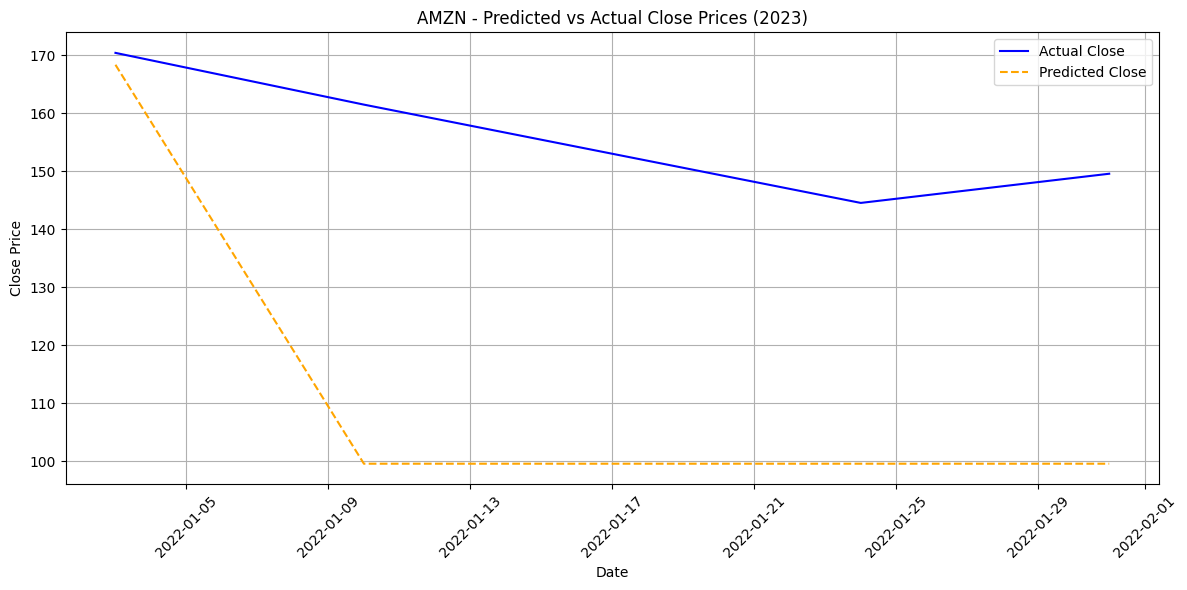

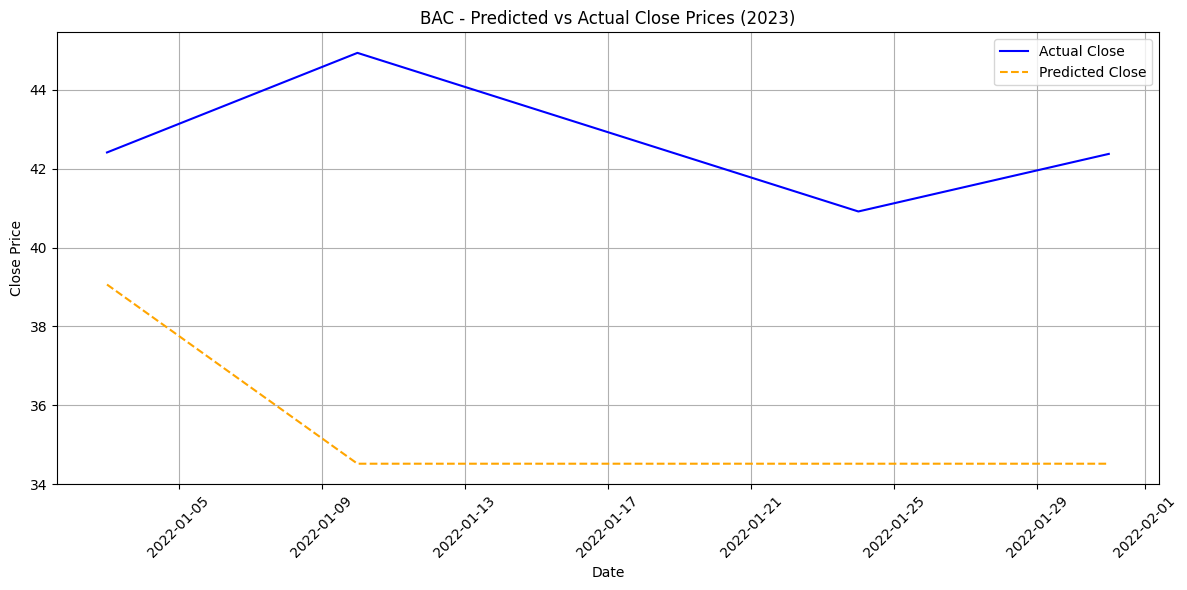

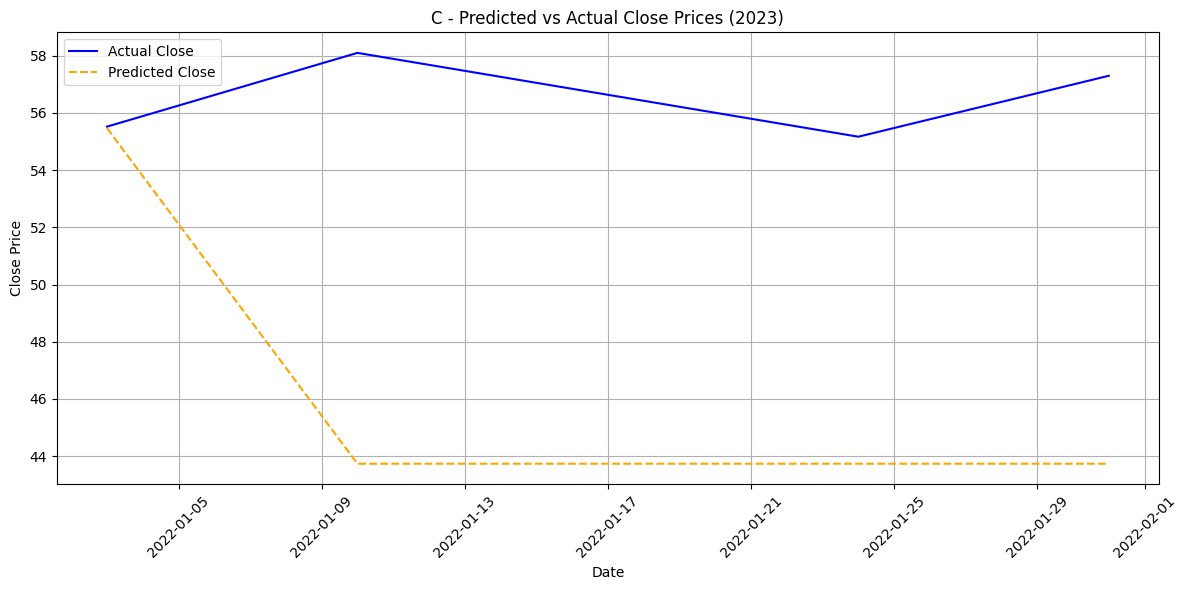

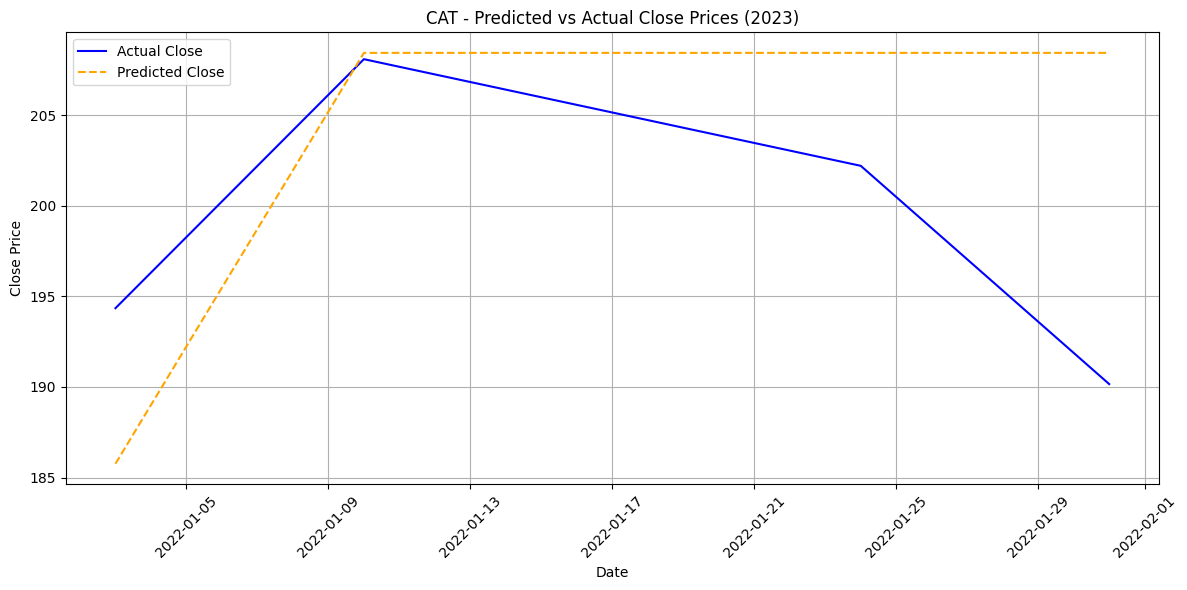

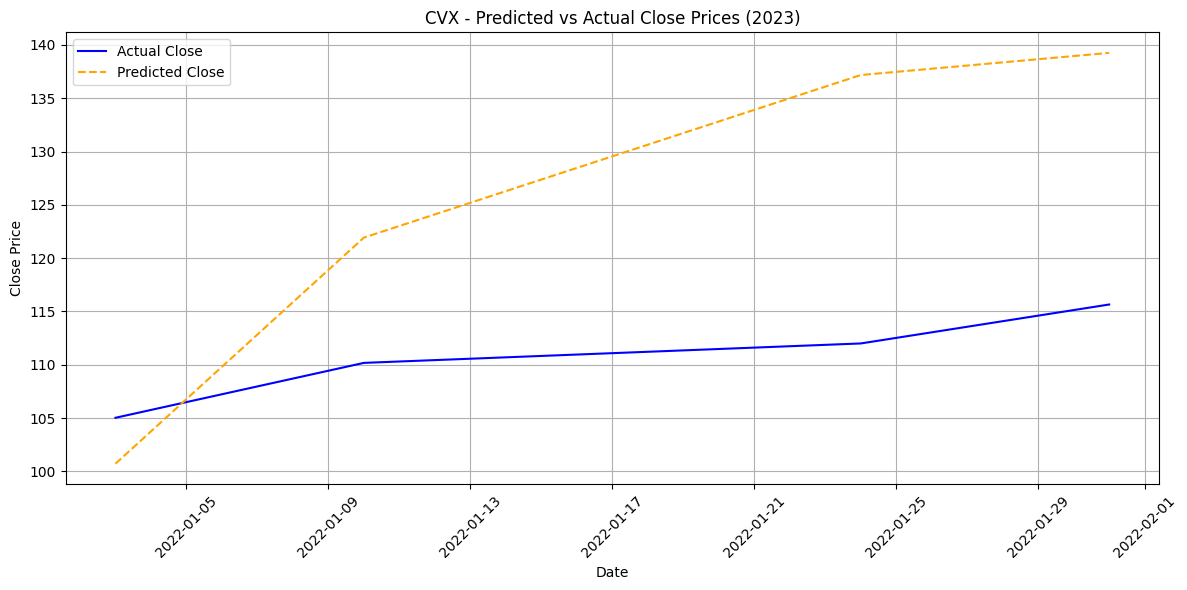

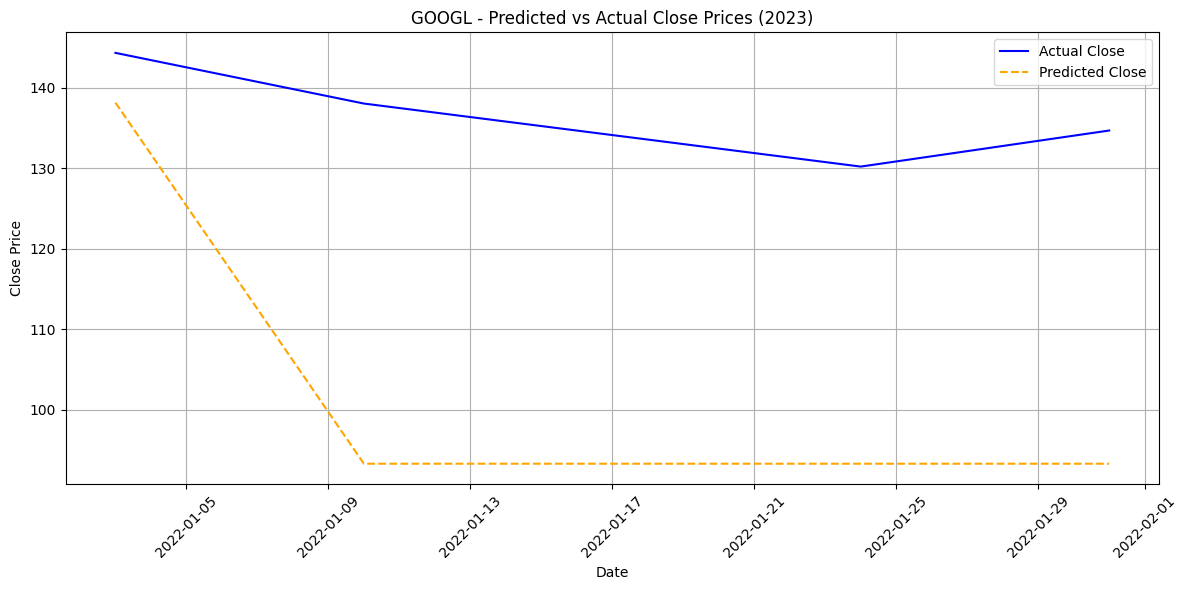

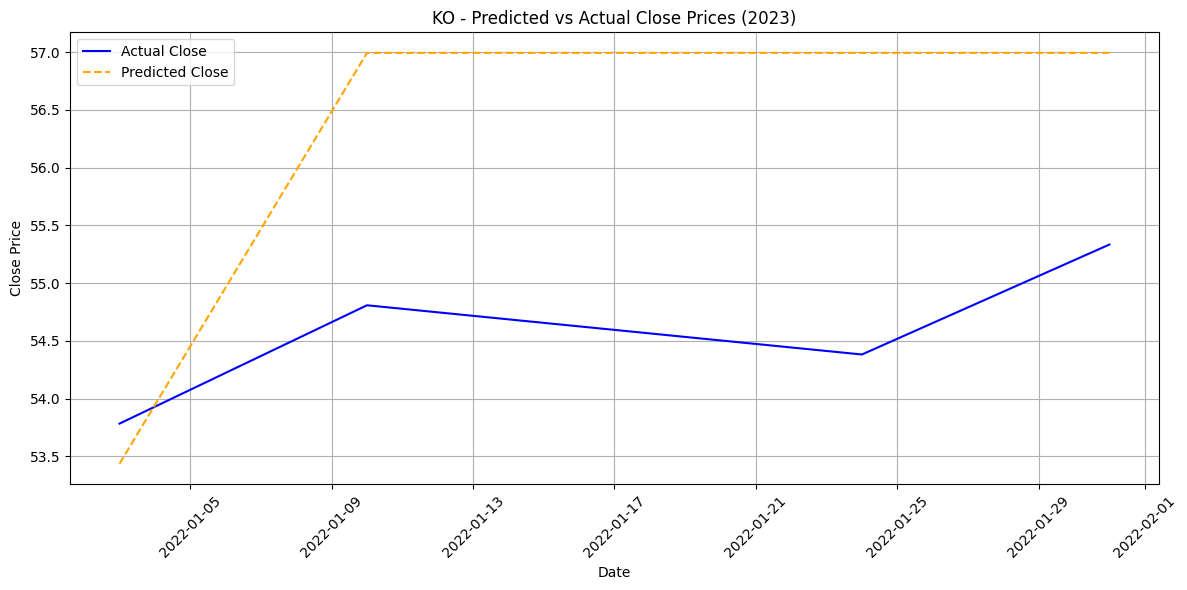

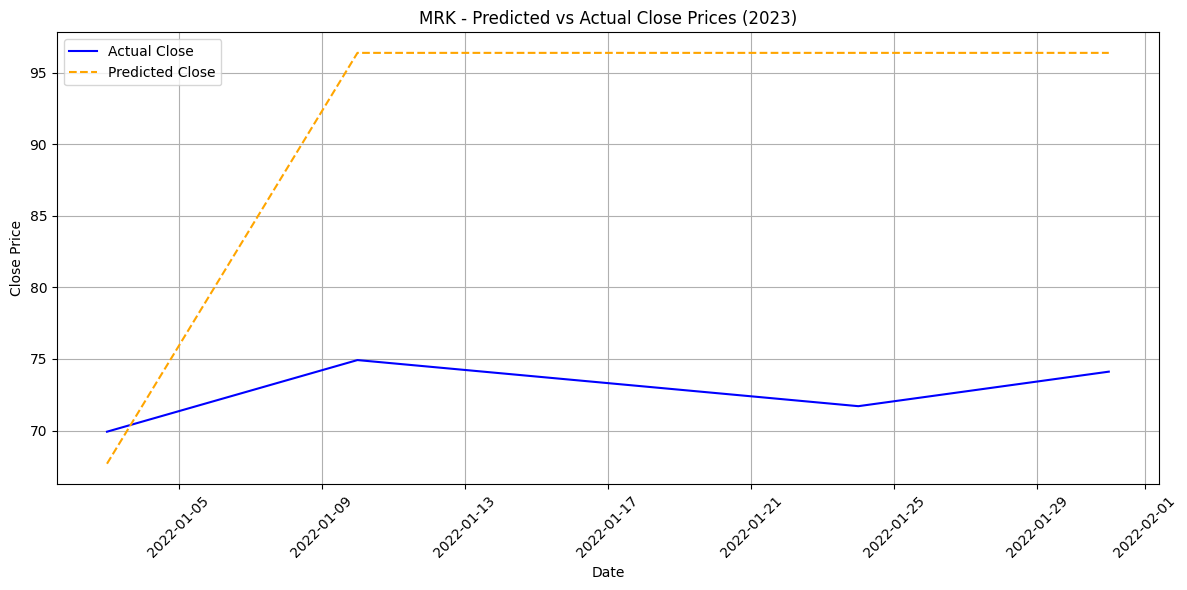

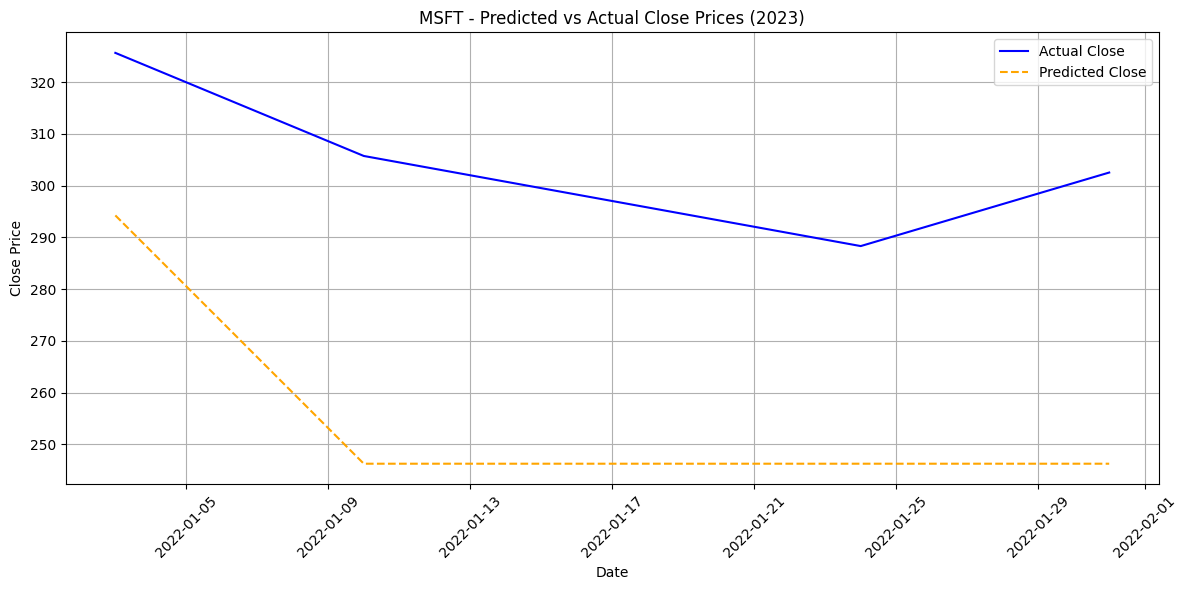

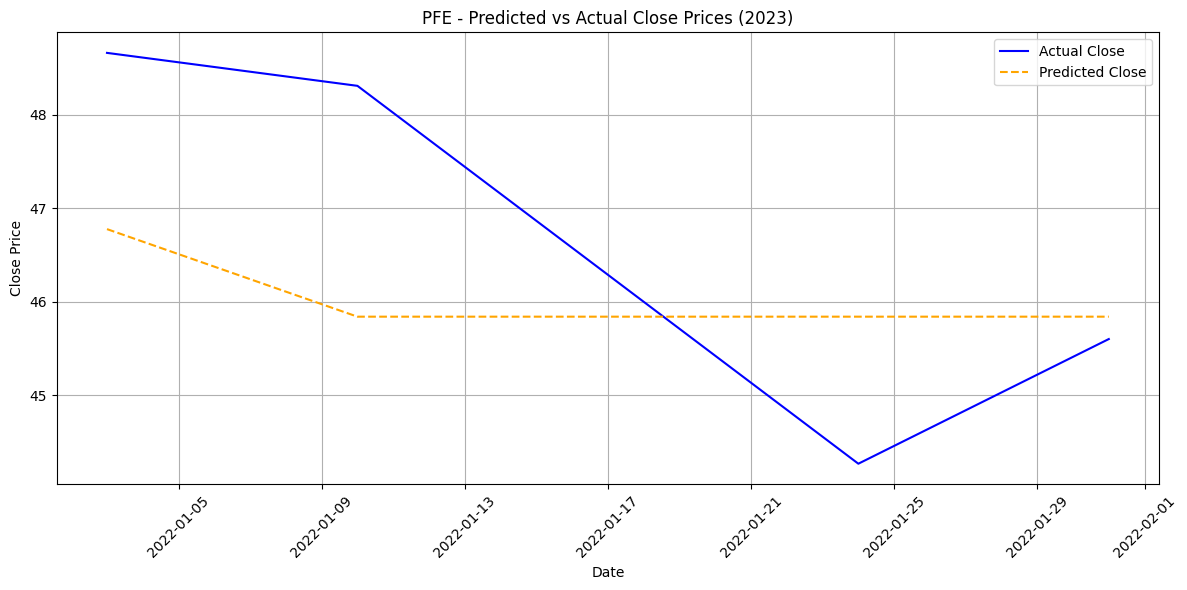

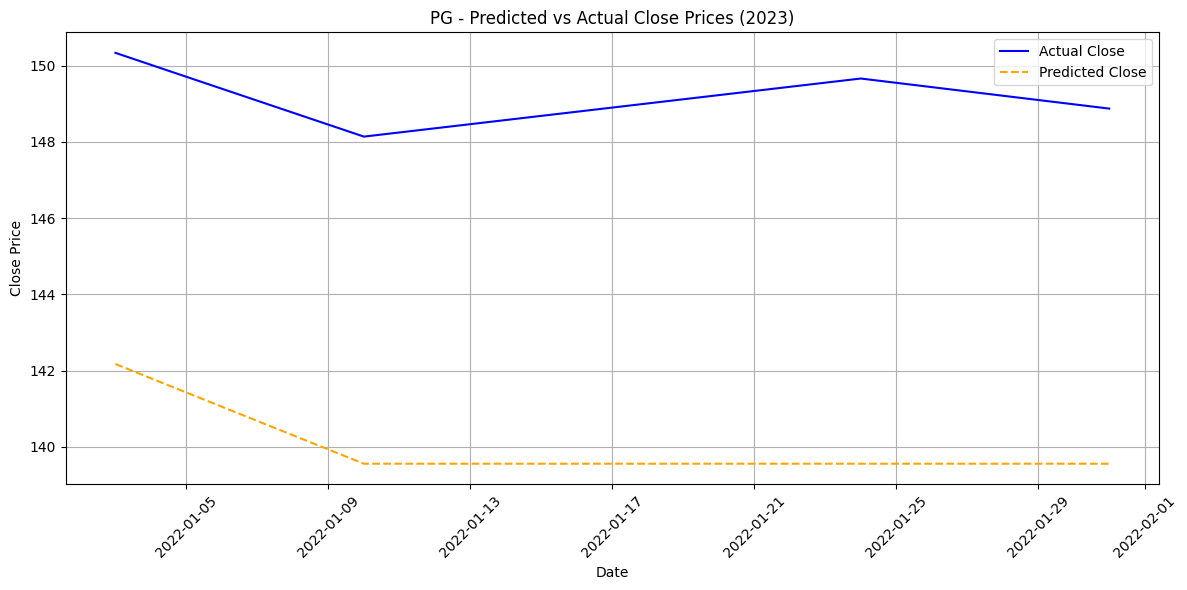

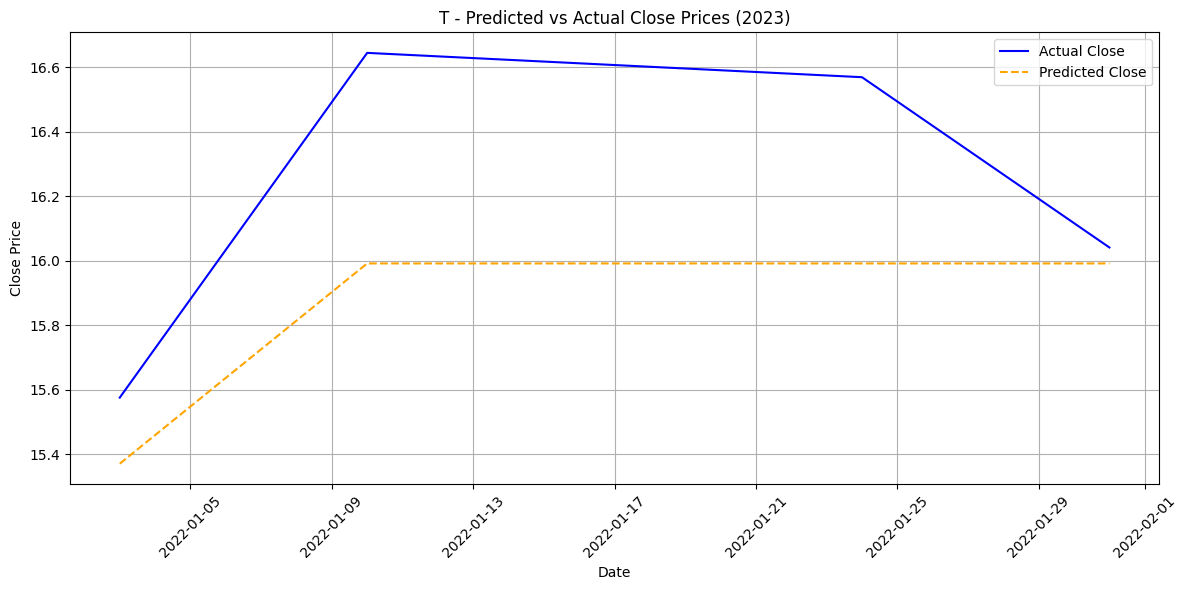

In [ ]:
for col in predictions.keys():
  plot_predictions_for_ticker(col, predictions, df_categorized_new, 3)

In [ ]:
predictions['AMZN']

[{'date': '2022-01-03',
  'predicted_open': np.float32(168.24988),
  'predicted_high': np.float32(170.29977),
  'predicted_low': np.float32(166.52692),
  'predicted_close': np.float32(168.35422),
  'predicted_volume': np.float32(70128740.0)},
 {'date': '2022-01-10',
  'predicted_open': np.float32(98.294945),
  'predicted_high': np.float32(100.18909),
  'predicted_low': np.float32(99.57906),
  'predicted_close': np.float32(99.59454),
  'predicted_volume': np.float32(68712820.0)},
 {'date': '2022-01-17',
  'predicted_open': np.float32(98.294945),
  'predicted_high': np.float32(100.18909),
  'predicted_low': np.float32(99.57906),
  'predicted_close': np.float32(99.59454),
  'predicted_volume': np.float32(68712820.0)},
 {'date': '2022-01-24',
  'predicted_open': np.float32(98.294945),
  'predicted_high': np.float32(100.18909),
  'predicted_low': np.float32(99.57906),
  'predicted_close': np.float32(99.59454),
  'predicted_volume': np.float32(68712820.0)},
 {'date': '2022-01-31',
  'predict

In [ ]:
predictions = generate_predictions_for_2023(
    model, df_categorized_new, test_tickers, scalers, ticker_to_idx,
    H, D_v_inv, D_e_inv, num_nodes=len(ticker_to_idx),
    feature_size=13, output_size=5, seq_length=30
)

In [ ]:
predictions["AMZN"]

[{'date': '2023-01-02',
  'predicted_open': np.float32(98.39966),
  'predicted_high': np.float32(100.29271),
  'predicted_low': np.float32(99.682014),
  'predicted_close': np.float32(99.70187),
  'predicted_volume': np.float32(68686136.0)},
 {'date': '2023-01-09',
  'predicted_open': np.float32(98.39966),
  'predicted_high': np.float32(100.29271),
  'predicted_low': np.float32(99.682014),
  'predicted_close': np.float32(99.70187),
  'predicted_volume': np.float32(68686136.0)},
 {'date': '2023-01-16',
  'predicted_open': np.float32(98.39966),
  'predicted_high': np.float32(100.29271),
  'predicted_low': np.float32(99.682014),
  'predicted_close': np.float32(99.70187),
  'predicted_volume': np.float32(68686136.0)},
 {'date': '2023-01-23',
  'predicted_open': np.float32(98.39966),
  'predicted_high': np.float32(100.29271),
  'predicted_low': np.float32(99.682014),
  'predicted_close': np.float32(99.70187),
  'predicted_volume': np.float32(68686136.0)},
 {'date': '2023-01-30',
  'predicted